# Lab 4: Comparison of Binary Classifiers
In this Lab I am going to use a classifier for training and evalutation with a dataset __seeds.csv__.
I will formulate a binary classification problem and transform the type column accordingly.
After that I will the train a third probabilistic classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest. 

In [215]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [216]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [217]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [218]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

First of all let's check for missing values and outliers.

In [219]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

Good there is no missing values, let's continue forward. I will now use blotplots to check for outliers in the dataset.

Removing spaces in the columns as they will provide problems when building a preprocessing pipeline

In [220]:
df.rename(columns = {'length of kernel':'length_of_kernel',
                     'width of kernel':'width_of_kernel',
                     'asymmetry coefficient':'asymmetry_coefficient',
                     'length of kernel groove':'length_of_kernel_groove'}, inplace = True)

In [221]:
df

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


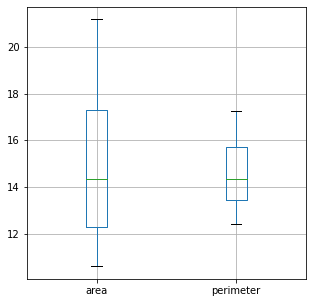

In [222]:
df.loc[:,'area':'perimeter'].boxplot(figsize=(5,5))
plt.show()

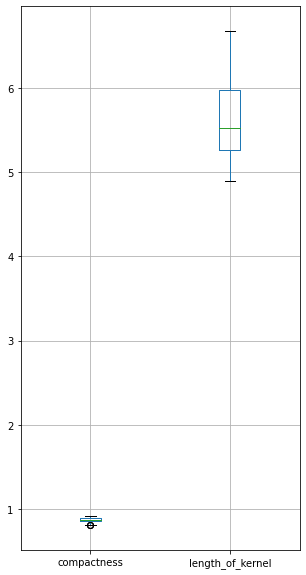

In [223]:
df.loc[:,'compactness':'length_of_kernel'].boxplot(figsize=(5,10))
plt.show()

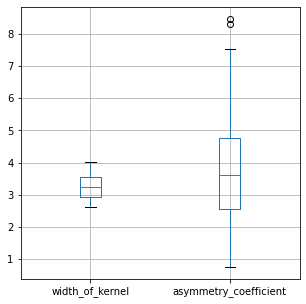

In [224]:
df.loc[:,'width_of_kernel':'asymmetry_coefficient'].boxplot(figsize=(5,5))
plt.show()

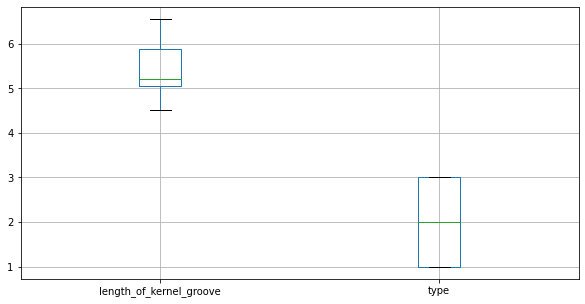

In [225]:
df.loc[:,'length_of_kernel_groove':'type'].boxplot(figsize=(10,5))
plt.show()

Judging by the boxplots above we can see that only the attribute __asymmetry coefficient__ has outliers in its set

# Data Preperation
I will attempt training SVM and Random Forest classifiers. I will tune their parameters, compare them and choose the best classifier for our problem. Here I will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which I will apply later. The use of this pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, I need to prepare two lists of column names. The list names_outliers contains the names of the three columns to which I will apply log transformation followed by RobustScaler. The list names_no_outliers contains the names of all other predictor columns to which we will apply StandardScaler.

In [226]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column with data preparatioN
names_outliers = ['asymmetry_coefficient','compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [227]:
names_no_outliers

['perimeter',
 'length_of_kernel',
 'area',
 'length_of_kernel_groove',
 'width_of_kernel']

In [228]:
names_outliers

['asymmetry_coefficient', 'compactness']

The reason I am storing the names of the columns in the list above is because after splitting the dataset into training and testing, the names of the columns are lost.
I will use the following class in the preprocessing pipeline to put the names of the columns back. I need this to easily apply the different preparation strategies to the two groups of columns.

In [229]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then I need another class to be able to select a particular group of columns.

In [230]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, I can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`.

In [231]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [232]:
preprocess_pipeline

Pipeline(steps=[('addcolumnnames',
                 AddColumnNames(columns=['area', 'perimeter', 'compactness',
                                         'length_of_kernel', 'width_of_kernel',
                                         'asymmetry_coefficient',
                                         'length_of_kernel_groove'])),
                ('featureunion',
                 FeatureUnion(transformer_list=[('outlier_columns',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(columns=['asymmetry_coefficient',
                                                                                          'compactness'])),
                                                                 ('functiontransformer',
                                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                    

Now I can separate the columns into target and predictors and split the dataset into a training and test sets.

In [237]:
from sklearn.svm import SVC
y = df['type']
X = df.drop('type', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# Creating the SVM model
model = OneVsRestClassifier(SVC())
   
# Fitting the model with training data
model.fit(X_train, y_train)
   
# Making a prediction on the test set
prediction = model.predict(X_test)
   
# Evaluating the model
print(f"Test Set Accuracy : {accuracy_score(y_test, prediction) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_test, prediction)}")

Test Set Accuracy : 90.47619047619048 %


Classification Report : 

              precision    recall  f1-score   support

           1       0.92      0.79      0.85        14
           2       0.88      1.00      0.93        14
           3       0.93      0.93      0.93        14

    accuracy                           0.90        42
   macro avg       0.91      0.90      0.90        42
weighted avg       0.91      0.90      0.90        42



The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why I needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters of Classifiers
Next, I train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this I will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [202]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.947:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


The parameter refit=True makes the GridSearchCV train an SVM classifier on the whole training set with the best parameters found. This best SVM model can then be accessed via the .best_estimator_ attribute of the GridSearchCV.

Let's repeat the same experiment but with the Random Forest classifier.

In [203]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.923:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 10}


## Compare Classifiers on Test Set
Now I can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which I will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, I need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, I take a scale of 100 equally spaced fpr values between 0 and 1.

In [195]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [204]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [205]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

ValueError: multiclass format is not supported